# 📖 Bible Reading Progress Tracker - Data Exploration

**Purpose:** Exploratory Data Analysis of WhatsApp group chat from a Bible Reading Group.

This notebook covers:

| # | Section | Description |
|---|---------|-------------|
| 1 | **Load Data** | Parse WhatsApp export and apply context labels |
| 2 | **Basic Statistics** | Message volume, sender activity, temporal patterns |
| 3 | **Progress Report Detection** | Keyword + Bible reference signals |
| 4 | **Pattern Analysis** | Message length, member engagement |
| 5 | **Temporal Trends** | Weekly/monthly activity over the full dataset |
| 6 | **Export** | Save filtered progress messages for downstream use |

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns
from pathlib import Path
import warnings
import sys

# suppress warnings in notebook
warnings.filterwarnings('ignore')

sys.path.append(str(Path('../').resolve()))

from src.preprocessing.parsing.whatsapp_parser import WhatsAppParser
from src.preprocessing.parsing.context_labeling import ContextLabeler
from src.utils.bible_reference_utils import BibleDataLoader, BibleReferenceAnnotator

# set style for plots
sns.set_style('darkgrid')   
plt.rcParams.update({
    'figure.figsize': (14, 5),
    'axes.titlesize': 15,
    'axes.titleweight': 'bold',
    'axes.labelsize': 12,
})
PALETTE = 'viridis'

---
## 1. Load Data

**Objective**  
Parse the raw WhatsApp `.txt` export and transform it into a structured dataset ready for analysis.

**Steps Performed**  
**1. WhatsApp Parsing**
- Detect Platform format (Android/iOS)
- Extract:
    - Timestamp
    - Sender
    - Message Text
- Handle multilines messages

In [2]:
CHAT_FILE = Path('../data/raw/whatsapp_exports/_chat.txt')

parser = WhatsAppParser()
labeler = ContextLabeler()

df = parser.parse_chat_file(CHAT_FILE)

print(f'messages parsed : {len(df)}')
print(f'Shape           : {df.shape}')
print(f'Columns         : {df.columns.tolist()}')

messages parsed : 19142
Shape           : (19142, 3)
Columns         : ['timestamp', 'sender', 'message']


**2. Context Labelling**  
Each message is labeled using heuristic rules into one or more of:
- `USER` – Regular user messages
-  `SYSTEM` – Group system notifications
-  `SHORT` – Very brief messages (likely progress)
-  `LONG` – Lengthy messages
-  `MEDIA` – Media attachments
-  `QUESTION` – Messages containing questions
-  `URL` – Messages containing links

In [3]:
labeled_df = labeler.label_messages(df)

print(f'Labeled DataFrame shape: {labeled_df.shape}')
labeled_df.head()

Labeled DataFrame shape: (19142, 5)


,timestamp,sender,message,primary_label,additional_labels
0,2020-08-02 11:41:31,Bible Reading Cycle 2,Pesan dan panggilan terenkripsi secara end-to-...,SYSTEM,[]
1,2020-08-02 11:41:31,Lenny Pandjidharma,Lenny Pandjidharma membuat grup “Bible Reading...,SYSTEM,[]
2,2020-08-02 11:41:31,Bible Reading Cycle 2,Lenny Pandjidharma menambahkan Anda,SYSTEM,[]
3,2020-08-02 11:41:43,Vik. Dessy Waiman,Lenny Pandjidharma menambahkan Vik. Dessy Waiman,SYSTEM,[]
4,2020-08-02 11:42:23,Lenny Pandjidharma,Lenny Pandjidharma mengubah deskripsi grup,SYSTEM,[]


**3. Label Statistics**  
We compute:
- Total counts per label
- Relative proportions
- Overall dataset size  

In [4]:
# Label distribution
stats = labeler.get_label_statistics(labeled_df)
print("Label Statistics:")
print(stats.to_string(index=False))

Label Statistics:
label_type    label  count percentage
   primary     USER  18679      97.58
   primary   SYSTEM    463       2.42
additional    SHORT  17321      90.49
additional    MEDIA    110       0.57
additional     LONG   1358       7.09
additional QUESTION    676       3.53
additional      URL     16       0.08


---
## 2. Basic Statistics

This section explores high-level engagement patterns in the group.

### 2.1 Top Senders

**Purpose**  
Identify the most active members in the group.

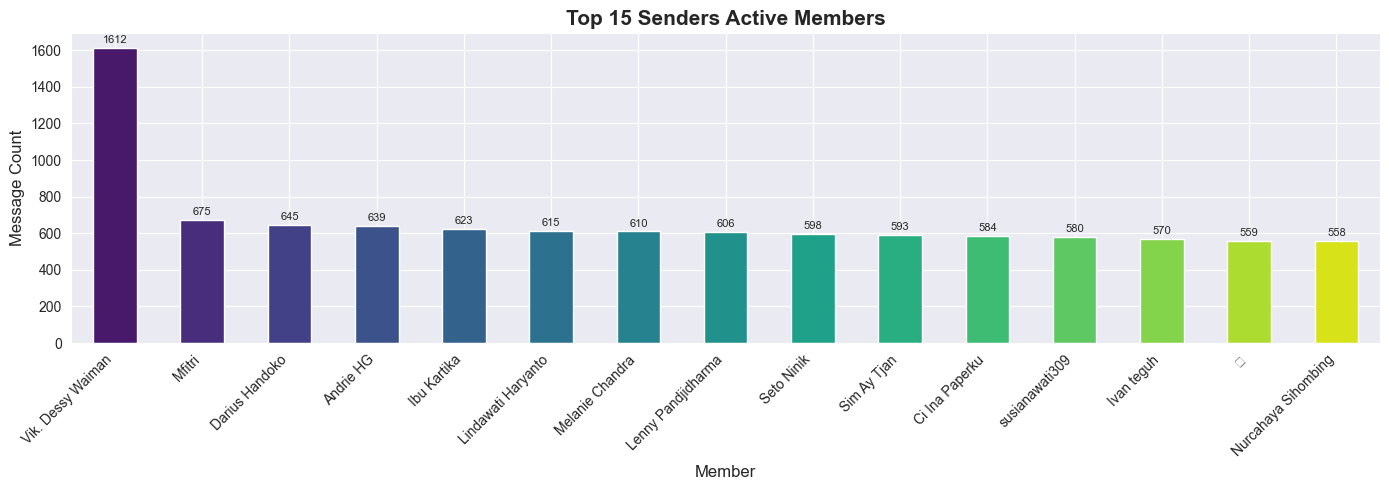

In [6]:
TOP_N = 15
sender_counts = labeled_df['sender'].value_counts().head(TOP_N)

ax = sender_counts.plot(kind='bar', color=sns.color_palette(PALETTE, TOP_N))
ax.set_title(f'Top {TOP_N} Senders Active Members')
ax.set_xlabel('Member')
ax.set_ylabel('Message Count')
ax.bar_label(ax.containers[0], fmt='%d', fontsize=8, padding=2)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### 2.2 Daily Message Volume

**Purpose**  
Understand how message activity fluctuates over time

In [7]:
messages_per_day = labeled_df.groupby(labeled_df['timestamp'].dt.date).size()

desc = messages_per_day.describe()
print(f"Mean   : {desc['mean']:.1f} messages/day")
print(f"Median : {desc['50%']:.1f} messages/day")
print(f"Max    : {int(desc['max'])} messages/day")
print(f"Min    : {int(desc['min'])} messages/day")

Mean   : 27.5 messages/day
Median : 28.0 messages/day
Max    : 86 messages/day
Min    : 1 messages/day


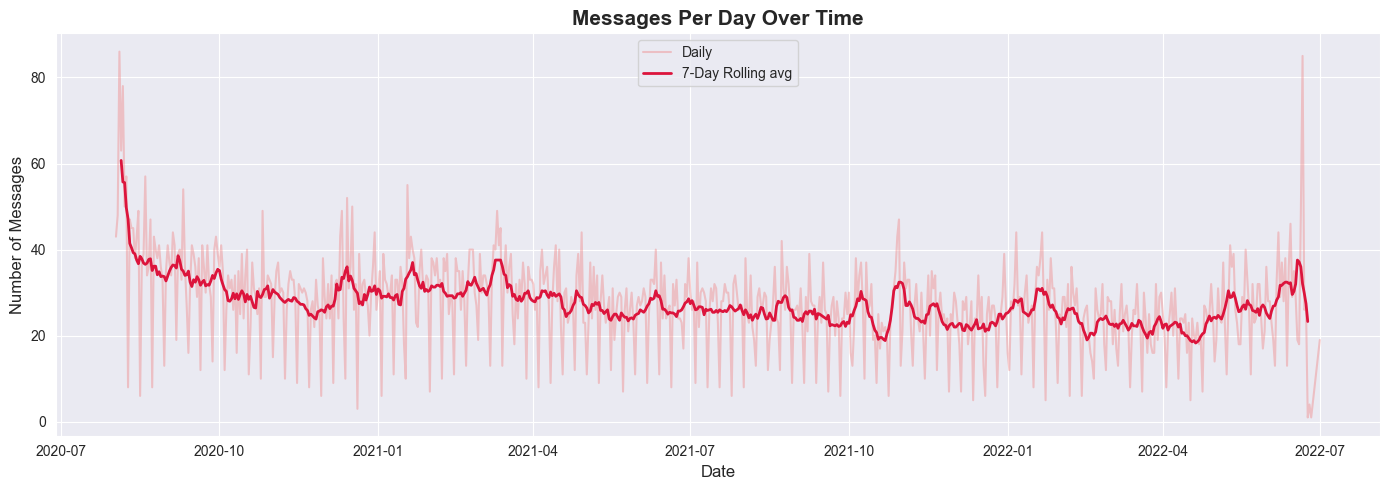

In [8]:
rolling7 = messages_per_day.rolling(window=7, center=True).mean()

plt.plot(messages_per_day.index, messages_per_day.values, 
         color='lightcoral', alpha=0.4, label='Daily')
plt.plot(rolling7.index, rolling7.values, 
         color='crimson', linewidth=2, label='7-Day Rolling avg')
plt.title('Messages Per Day Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Messages')
plt.legend()
plt.tight_layout()
plt.show()

### 2.3 Messages by Hour of Day

**Purpose**  
Discover the most active hours in the group.

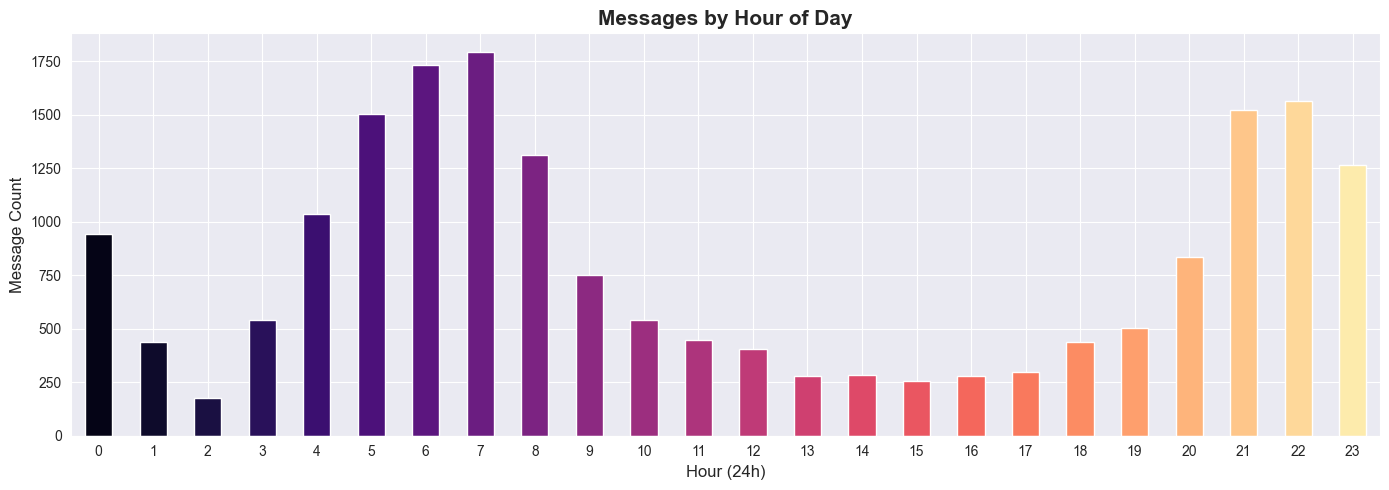

In [9]:
messages_per_hour = labeled_df.groupby(labeled_df['timestamp'].dt.hour).size()

ax = messages_per_hour.plot(kind='bar', color=sns.color_palette('magma', 24))
plt.title('Messages by Hour of Day')
plt.xlabel('Hour (24h)')
plt.ylabel('Message Count')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

### 2.4 Activity Heatmap - Hour x Day of Week

**Purpose**  
Provide a 2D view of *when* the group is most active.

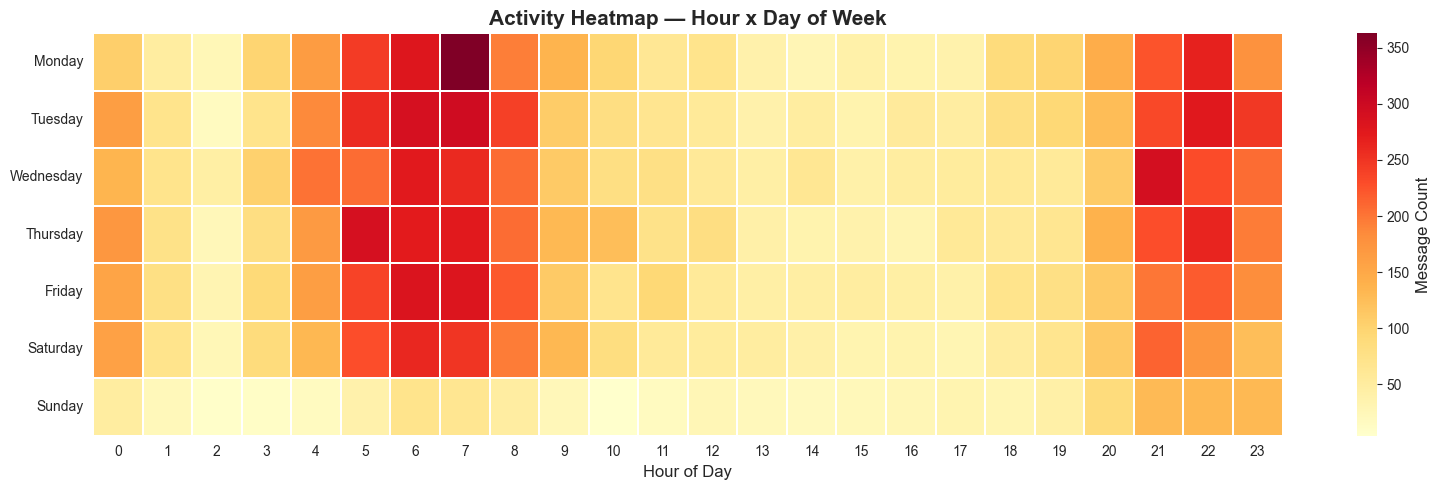

In [10]:
labeled_df['hour']    = labeled_df['timestamp'].dt.hour
labeled_df['weekday'] = labeled_df['timestamp'].dt.day_name()

DAYS_ORDER = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']

heatmap_data = (
    labeled_df.groupby(['weekday', 'hour'])
    .size()
    .unstack(fill_value=0)
    .reindex(DAYS_ORDER)
)

fig, ax = plt.subplots(figsize=(16, 5))
sns.heatmap(heatmap_data, cmap='YlOrRd', linewidths=0.3, ax=ax,
            cbar_kws={'label': 'Message Count'})
ax.set_title('Activity Heatmap — Hour x Day of Week')
ax.set_xlabel('Hour of Day')
ax.set_ylabel('')
plt.tight_layout()
plt.show()

### 2.5 Message Length Distribution

**Purpose**  
Understand communication style in the group.

In [11]:
message_lengths = labeled_df['message'].str.len()

print(f'Mean   : {message_lengths.mean():.2f} chars')
print(f'Median : {message_lengths.median():.2f} chars')
print(f'Std    : {message_lengths.std():.2f} chars')

Mean   : 147.30 chars
Median : 15.00 chars
Std    : 606.41 chars


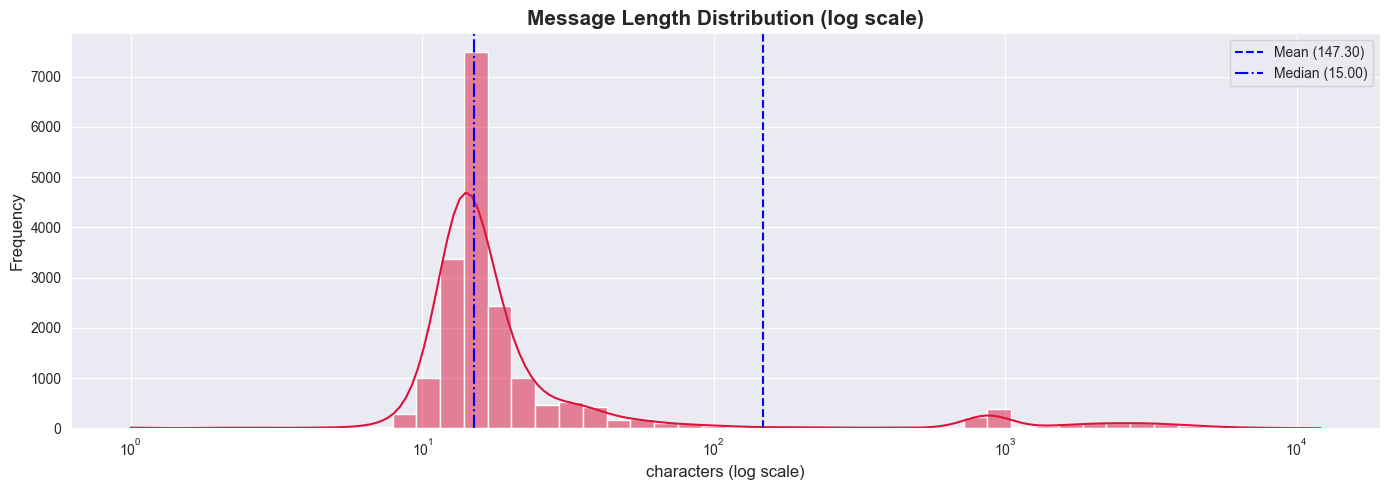

In [12]:
sns.histplot(message_lengths, bins=50, color='crimson', alpha=0.5, 
             kde=True, log_scale=True)
plt.axvline(np.mean(message_lengths), color='blue', linestyle='--', 
            label=f'Mean ({message_lengths.mean():.2f})')
plt.axvline(np.median(message_lengths), color='blue', linestyle='-.', 
            label=f'Median ({message_lengths.median():.2f})')

plt.title('Message Length Distribution (log scale)')
plt.xlabel('characters (log scale)')
plt.ylabel('Frequency')
plt.legend()
plt.tight_layout()
plt.show()

### 2.6 Message Lines Distribution

**Purpose**  
Understand the structure of messages by analyzing how many lines each message contains.

In [13]:

num_lines = labeled_df['message'].str.count('\n') + 1

print(f'Mean   : {num_lines.mean():.2f} lines')
print(f'Median : {num_lines.median():.2f} lines')
print(f'Std    : {num_lines.std():.2f} lines')

Mean   : 3.88 lines
Median : 1.00 lines
Std    : 10.98 lines


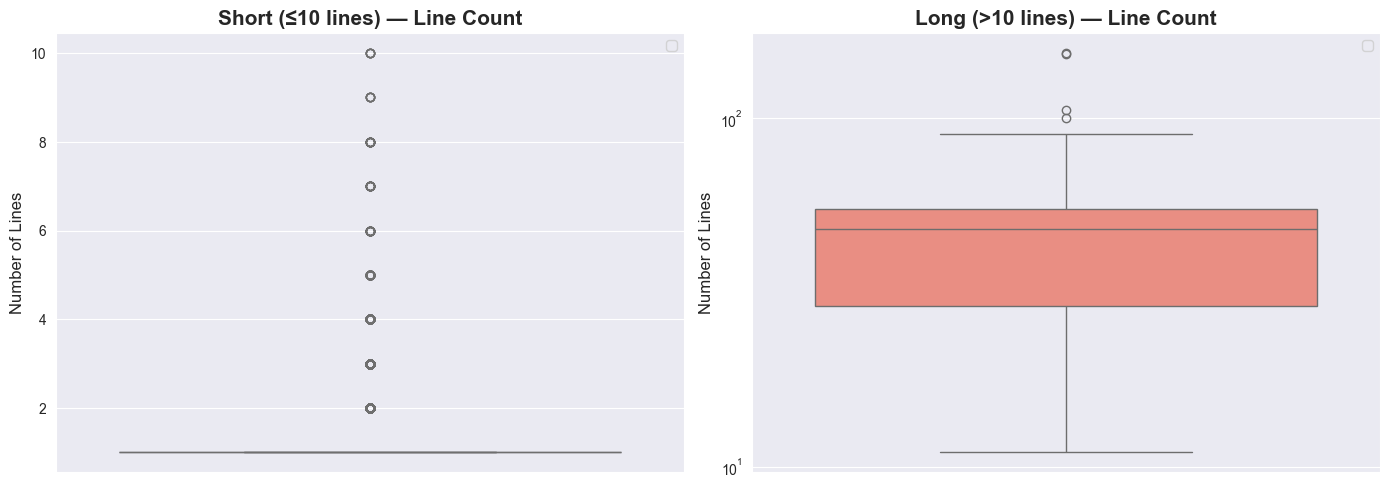

In [15]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

for ax, data, label, color, logscale in [
    (ax1, num_lines[num_lines <= 10], 'Short (≤10 lines)', 'skyblue', False),
    (ax2, num_lines[num_lines > 10],  'Long (>10 lines)',  'salmon',  True),
]:
    sns.boxplot(y=data, ax=ax, color=color)

    ax.set_title(f'{label} — Line Count')
    ax.set_ylabel('Number of Lines')

    if logscale:
        ax.set_yscale('log')

    ax.legend()

plt.tight_layout()
plt.show()

---
## 3. Progress Report Detection

**Objective**  
Automatically detect messages that likely represent daily reading progress reports.

We combine two strong signals:

1. Progress keywords
2. Bible Reference Mentions

Only when both are present do we flag a message as likely progress.

### 3.1 Keyword Flagging

**Approach**  
Search for terms like: *done*, *selesai*, *finish*, and other similiar completion indicators.

**Output**  
Boolean column of `has_progress_keyword`

**Rationale**  
Completion language strongly signal reporting behavior.

In [16]:
progress_keywords = ['done', 'selesai', 'sudah', 'finish', '✓', '✅', '☑', '💥']

labeled_df['has_progress_keyword'] = labeled_df['message'].str.lower().apply(
    lambda x: any(kw in x for kw in progress_keywords)
)

kw_count = labeled_df['has_progress_keyword'].sum()
print(f'Messages with a progress keyword : {kw_count:,} ({kw_count / len(labeled_df) * 100:.2f}&)')

labeled_df[labeled_df['has_progress_keyword']][['sender', 'message']].head(10)

Messages with a progress keyword : 16,420 (85.78&)


,sender,message
7,"dr. Andreas C.N., Fp.B.",Siap terimakasih sudah diadd di grup 🙏🏻
25,Vik. Dessy Waiman,*Introduksi Kitab Kejadian*\n\n*Judul*\n\nTuha...
28,Vik. Dessy Waiman,"Selamat malam bpk, ibu, sdr, sdri,\nSelamat be..."
30,Vik. Dessy Waiman,"**Bible Reading Cycle 2, 3 Agst 2020**\n\n*📖 G..."
37,Vik. Dessy Waiman,"Selamat malam bpk, ibu, sdr, sdri,\nSelamat be..."
38,Vik. Dessy Waiman,*Introduksi Kitab Kejadian*\n\n*Judul*\n\nTuha...
40,Vik. Dessy Waiman,"**Bible Reading Cycle 2, 3 Agst 2020**\n\n*📖 G..."
43,Melanie Chandra,Kej 1-2 done
44,Lindawati Haryanto,Kej 1-2 done
45,Sherly Cahyadi,Kej 1-2 done


### 3.2 Bible Reference Annotation

**Approach**  
Use a Bible reference util to detect patterns like:
- Book + Chapter
- Chapter Ranges
- Cross-book Ranges

**Output**  
- Counnt of references
- Structured reference extraction

**Why it matters**  
A reading report almost always includes at least one Bible reference.

In [17]:
loader = BibleDataLoader()
bible_books = loader.load_default()
annotator = BibleReferenceAnnotator(bible_books)

# On2ly annotate short USER messages - they carry reading reports
mask = (
    (labeled_df["primary_label"] == "USER") &
    (labeled_df["additional_labels"].apply(lambda x: x == ["SHORT"]))
)

annotated_subset = annotator.annotate_dataframe(labeled_df.loc[mask])
cols = ["bible_references", "bible_ref_count", "ner_spans", "labels"]
labeled_df.loc[mask, cols] = annotated_subset[cols]


total_refs = (labeled_df["labels"] == True).sum()
print(f'Messages with Bible references : {total_refs:,} ({total_refs / len(labeled_df) * 100:.1f}%)')


Messages with Bible references : 16,186 (84.6%)


### 3.3 Combining Signals - Likely Progress Flag

**Logic**  
A message is flagged as `likely_progress` if:
- `has_progress_keyword` == True AND
- `bible_reference_count` > 0 

**Why Combine?**  
- Keyword alone → Too Noisy
- Bible reference alone → Could be discussion
- Both together → Strong reading-report signal

This creates a high-precision heuristic filter.

In [18]:
labeled_df['likely_progress'] = (
    labeled_df['has_progress_keyword'] & (labeled_df['labels'] == True)
)

n_progress = labeled_df['likely_progress'].sum()
print(f'Messages with Bible references : {n_progress:,} ({n_progress / len(labeled_df) * 100:.1f}%)')

# Detection funnel
funnel = pd.Series({
    'All messages'            : len(labeled_df),
    'Has progress keyword'    : labeled_df['has_progress_keyword'].sum(),
    'Has Bible reference'     : int(total_refs),
    'Likely progress (both)'  : n_progress,
})
print(f'\nDetection funnel:')
print(funnel.to_string())

print('\nSample likely-progress messages:')
labeled_df[labeled_df['likely_progress']][['sender', 'message']].head(10)

Messages with Bible references : 15,757 (82.3%)

Detection funnel:
All messages              19142
Has progress keyword      16420
Has Bible reference       16186
Likely progress (both)    15757

Sample likely-progress messages:


,sender,message
43,Melanie Chandra,Kej 1-2 done
44,Lindawati Haryanto,Kej 1-2 done
45,Sherly Cahyadi,Kej 1-2 done
46,Seto Ninik,Kej 1-2 done
47,🪸Martha 🍁,Kej 1-2 done
48,Dewi Pratiwi,Kej 1-2 done
49,Endang Surati,Kej 1- 2 selesai.🙏
50,Dicky Andrian,Kej 1-2 done
51,🎍,Kej 1-2 done
52,"dr. Andreas C.N., Sp.B.",Kej 1-2 selesai


---
## 4. Pattern Analysis

This section compares progress messages vs general messages

### 4.1 Message Length: Progress vs Non-Progress

**Question**  
Are progress reports shorter than general messages?

**Analysis**  
- Compare length distribution
- Visualize side-by-side

**Expected Insight**  
Progress reports are typically short and structured, while Non-progress messages may include Casual chat, Discussion, Reflection, Questions and others.

In [19]:

labeled_df['message_length'] = labeled_df['message'].str.len()

progress_lengths = labeled_df[labeled_df['likely_progress']]['message_length']
non_progress_lengths = labeled_df[~labeled_df['likely_progress']]['message_length']

print('Progress messages     — mean:', f'{progress_lengths.mean():.2f}',
      '  median:', f'{progress_lengths.median():.2f}')
print('Non-progress messages — mean:', f'{non_progress_lengths.mean():.2f}',
      '  median:', f'{non_progress_lengths.median():.2f}')

Progress messages     — mean: 17.04   median: 14.00
Non-progress messages — mean: 753.63   median: 51.00


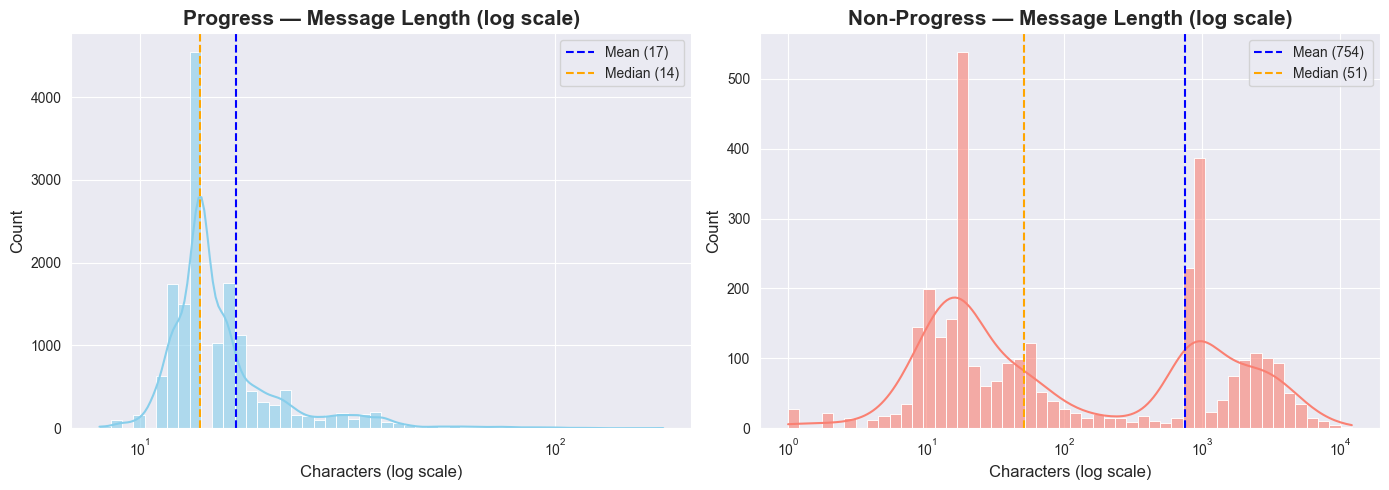

In [20]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
for ax, data, label, color in [
    (ax1, progress_lengths, 'Progress', 'skyblue'),
    (ax2, non_progress_lengths, 'Non-Progress', 'salmon'),
]:
    sns.histplot(data, bins=50, color=color, alpha=0.6, kde=True,
                 log_scale=True, ax=ax)
    ax.axvline(data.mean(),   color='blue',   linestyle='--', label=f'Mean ({data.mean():.0f})')
    ax.axvline(data.median(), color='orange', linestyle='--', label=f'Median ({data.median():.0f})')
    ax.set_title(f'{label} — Message Length (log scale)')
    ax.set_xlabel('Characters (log scale)')
    ax.legend()

plt.tight_layout()
plt.show()

### 4.2 Progress Reports by Member (Top 20)

**Purpose**  
Indetify the most committed readers.

In [21]:
progress_by_member = (
    labeled_df[labeled_df['likely_progress']]
    .groupby('sender')
    .size()
    .sort_values(ascending=False)
)

top20 = progress_by_member.head(20)
print(top20.to_string())

sender
Mfitri                      621
Lindawati Haryanto          600
Seto Ninik                  587
Darius Handoko              582
Andrie HG                   579
Ci Ina Paperku              575
susianawati309              564
Ivan teguh                  562
Sim Ay Tjan                 559
Melanie Chandra             553
🎍                           547
Nurcahaya Sihombing         546
Lenny Pandjidharma          535
Dewi Pratiwi                533
Ibu Kartika                 520
Ruri Handoko                495
Kristin WIjaya Nusantara    449
Endang Surati               444
Tjunfebelyana               412
Agnes                       403


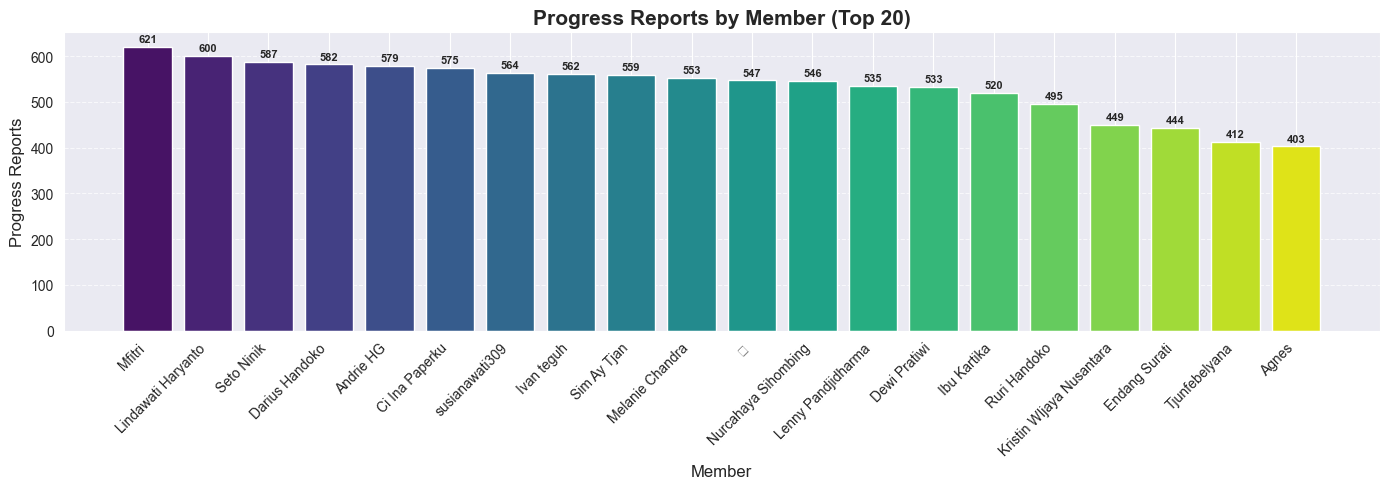

In [22]:
fig, ax = plt.subplots(figsize=(14, 5))
bars = ax.bar(top20.index, top20.values,
              color=sns.color_palette(PALETTE, len(top20)))
ax.bar_label(bars, fmt='%d', fontsize=8, padding=2, fontweight='bold')
ax.set_title('Progress Reports by Member (Top 20)')
ax.set_xlabel('Member')
ax.set_ylabel('Progress Reports')
ax.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### 4.3 Member Consistency — Actuve Days vs Total Reports

**Purpose**  
Differentiate between:
- Prolific reporters → High total count
- Consistent reporters → Report across many distinct days

**Interpretation**

| # | Scenario | Meaning |
|---|---------|-------------|
| 1 | High reports + high active days | Consistent daily reader |
| 2 | High reports + low active days | Multiple reports in fewer days |
| 3 | Low reports + high active days | Occasional but consistent |


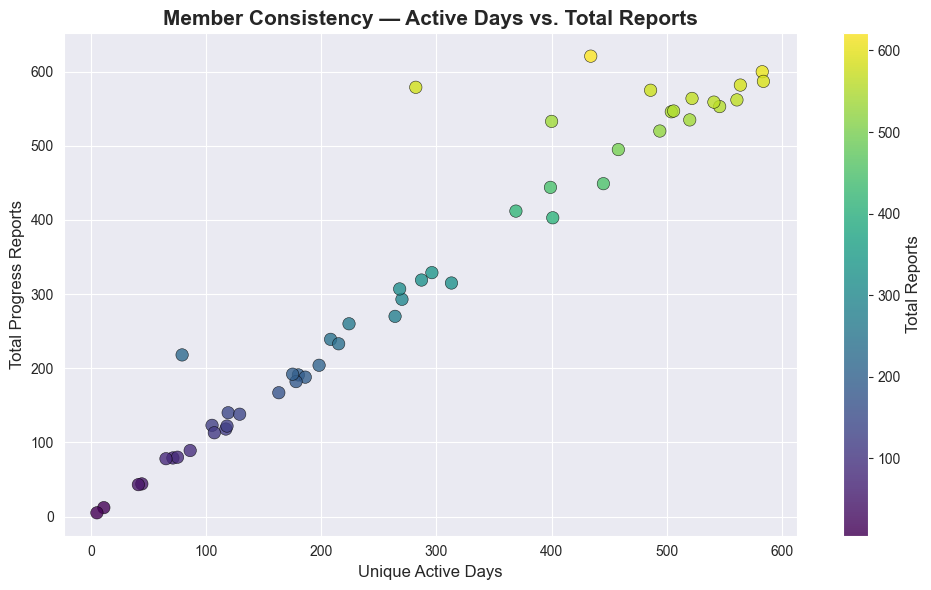

In [23]:
prog_df = labeled_df[labeled_df['likely_progress']].copy()
prog_df['date'] = prog_df['timestamp'].dt.date

member_stats = prog_df.groupby('sender').agg(
    total_reports = ('message', 'count'),
    active_days = ('timestamp', lambda x: x.dt.date.nunique()),
).reset_index()

# onlt plot members with 5+ reports
plot_data = member_stats[member_stats['total_reports'] >= 5]

fig, ax = plt.subplots(figsize=(10, 6))
sc = ax.scatter(
    plot_data['active_days'], plot_data['total_reports'],
    c=plot_data['total_reports'], cmap=PALETTE, s=80, alpha=0.8,
    edgecolors='k', linewidths=0.4
)
plt.colorbar(sc, ax=ax, label='Total Reports')
ax.set_title('Member Consistency — Active Days vs. Total Reports')
ax.set_xlabel('Unique Active Days')
ax.set_ylabel('Total Progress Reports')
plt.tight_layout()
plt.show()

---
## 5. Temporal Trends

### 5.1 Monthly Message Volume

**Purpose**  
Understand long-term group activity.

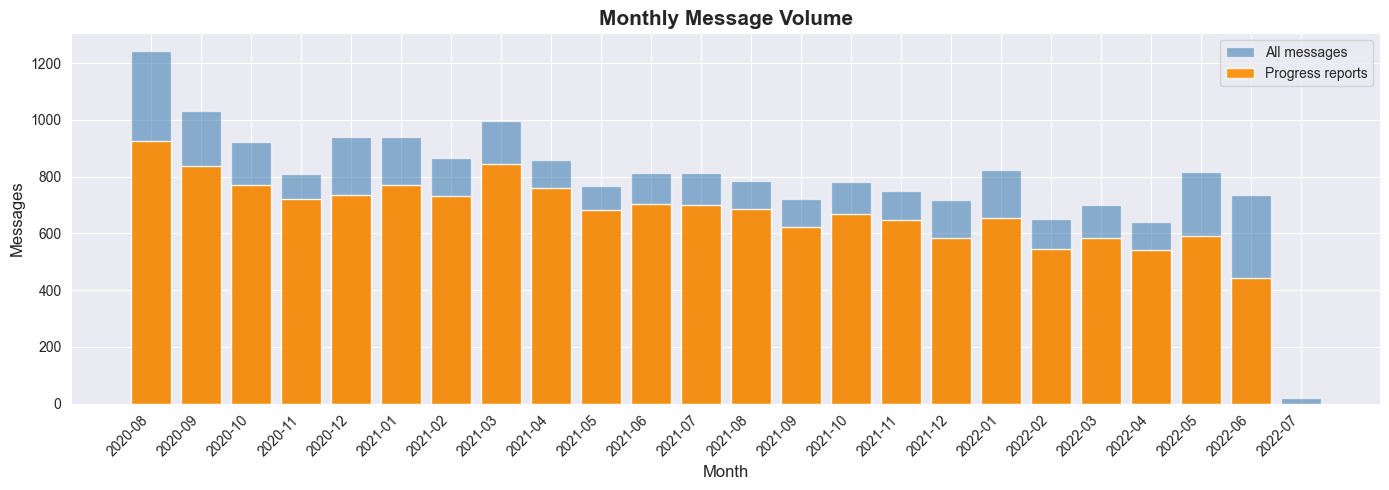

In [32]:

monthly_all = labeled_df.groupby(
    labeled_df['timestamp'].dt.to_period('M')
).size()

monthly_progress = labeled_df[labeled_df['likely_progress']].groupby(
    labeled_df['timestamp'].dt.to_period('M')
).size()

fig, ax = plt.subplots(figsize=(14, 5))
ax.bar(monthly_all.index.astype(str),      monthly_all.values,
       color='steelblue', alpha=0.6, label='All messages')
ax.bar(monthly_progress.index.astype(str), monthly_progress.values,
       color='darkorange', alpha=0.9, label='Progress reports')
ax.set_title('Monthly Message Volume')
ax.set_xlabel('Month')
ax.set_ylabel('Messages')
ax.legend()
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### 5.2 Day-of-Week Reporting Pattern

**Purpose**  
Detect weekly rhythm in reading reports.

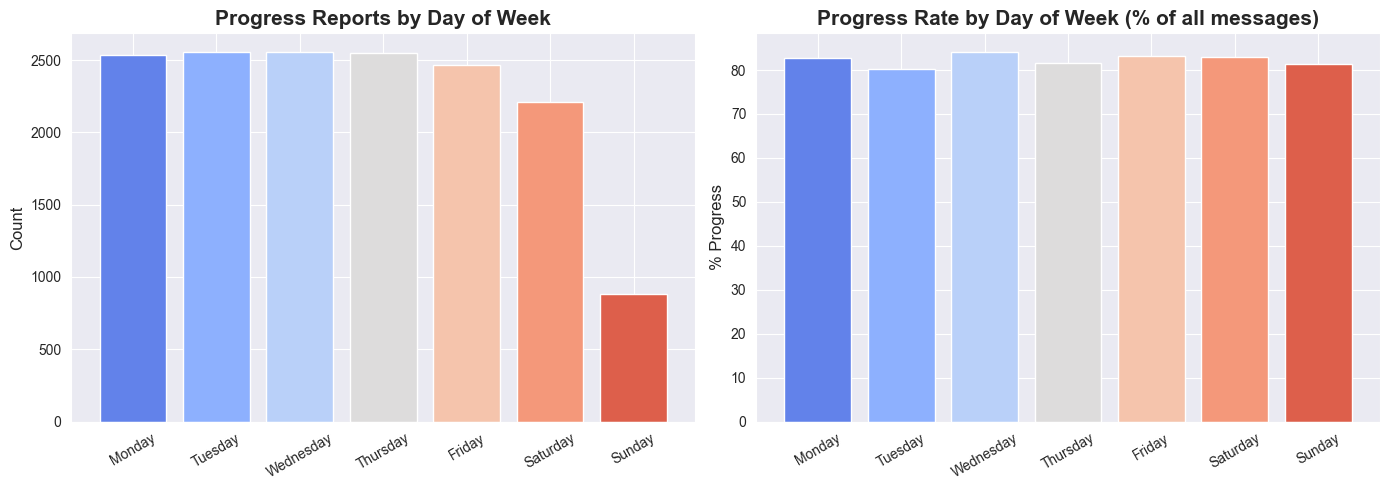

In [34]:
DAYS_ORDER = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']



dow_all = labeled_df.groupby(
    labeled_df['timestamp'].dt.day_name()
    ).size().reindex(DAYS_ORDER)

dow_progress = (
    labeled_df[labeled_df['likely_progress']].groupby(
        labeled_df['timestamp'].dt.day_name()
        ).size().reindex(DAYS_ORDER)
)
dow_rate = (dow_progress / dow_all * 100).fillna(0)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].bar(DAYS_ORDER, dow_progress.values, color=sns.color_palette('coolwarm', 7))
axes[0].set_title('Progress Reports by Day of Week')
axes[0].set_ylabel('Count')
axes[0].tick_params(axis='x', rotation=30)

axes[1].bar(DAYS_ORDER, dow_rate.values, color=sns.color_palette('coolwarm', 7))
axes[1].set_title('Progress Rate by Day of Week (% of all messages)')
axes[1].set_ylabel('% Progress')
axes[1].tick_params(axis='x', rotation=30)

plt.tight_layout()
plt.show()

### Unique Active Members Over Time

**Purpose**  
Measure engagement breadth, not just volume

**Why it's Important**  
- Indicates community health
- Show retention vs decline
- Detect engagement expansion

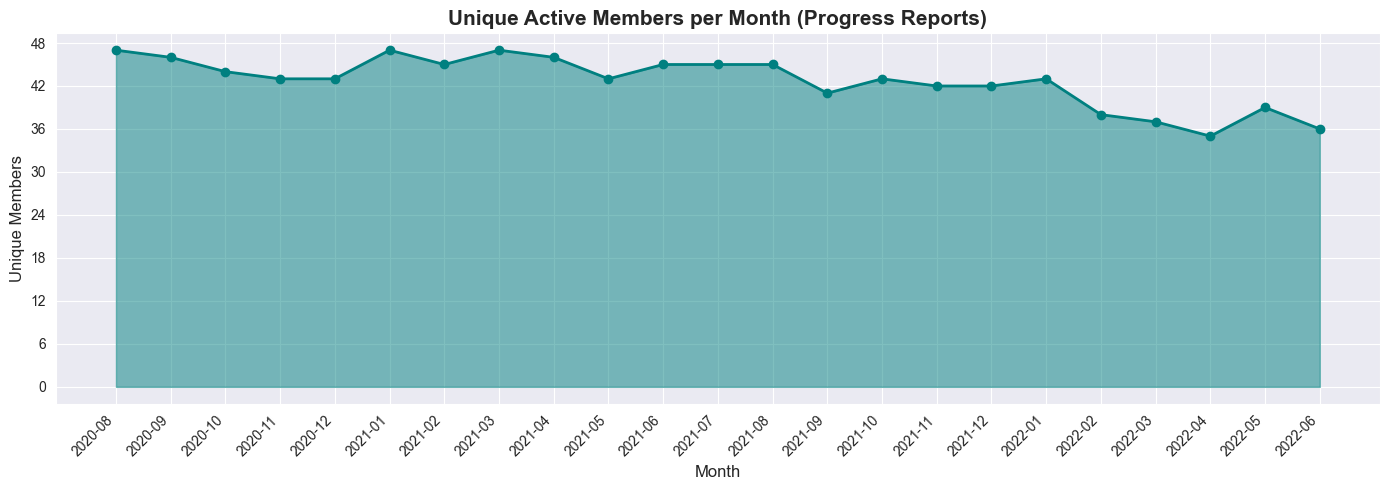

In [39]:
monthly_unique_members = (
    labeled_df[labeled_df['likely_progress']]
    .groupby(labeled_df['timestamp'].dt.to_period('M'))['sender']
    .nunique()
)

fig, ax = plt.subplots(figsize=(14, 5))
ax.plot(monthly_unique_members.index.astype(str), 
        monthly_unique_members.values,
        marker='o', color='teal', linewidth=2)
ax.fill_between(monthly_unique_members.index.astype(str), 
                monthly_unique_members.values,
                alpha=0.5, color='teal')
ax.set_title('Unique Active Members per Month (Progress Reports)')
ax.set_xlabel('Month')
ax.set_ylabel('Unique Members')
ax.yaxis.set_major_locator(mticker.MaxNLocator(integer=True))
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

---
## 6. Export

Save filtered progress-report messages for downstream modelling / reporting.

In [40]:
OUT_DIR = Path('../data/processed')

progress_df = labeled_df[labeled_df["likely_progress"] == True]
out_path = OUT_DIR / 'likely_progress_messages.csv'

progress_df.to_csv(out_path, index=False, encoding="utf-8-sig")

print(f'Saved {len(progress_df):,} rows to {out_path}')
progress_df.head()


Saved 15,757 rows to ..\data\processed\likely_progress_messages.csv


,timestamp,sender,message,primary_label,additional_labels,hour,weekday,has_progress_keyword,bible_references,bible_ref_count,ner_spans,labels,likely_progress,message_length
43,2020-08-03 03:48:55,Melanie Chandra,Kej 1-2 done,USER,[SHORT],3,Monday,True,"[{'book_start': 'Kej', 'start_chapter': 1, 'bo...",1.0,"[{'start': 0, 'end': 3, 'label': 'BOOK', 'text...",True,True,12
44,2020-08-03 04:03:51,Lindawati Haryanto,Kej 1-2 done,USER,[SHORT],4,Monday,True,"[{'book_start': 'Kej', 'start_chapter': 1, 'bo...",1.0,"[{'start': 0, 'end': 3, 'label': 'BOOK', 'text...",True,True,12
45,2020-08-03 04:08:44,Sherly Cahyadi,Kej 1-2 done,USER,[SHORT],4,Monday,True,"[{'book_start': 'Kej', 'start_chapter': 1, 'bo...",1.0,"[{'start': 0, 'end': 3, 'label': 'BOOK', 'text...",True,True,12
46,2020-08-03 04:32:19,Seto Ninik,Kej 1-2 done,USER,[SHORT],4,Monday,True,"[{'book_start': 'Kej', 'start_chapter': 1, 'bo...",1.0,"[{'start': 0, 'end': 3, 'label': 'BOOK', 'text...",True,True,12
47,2020-08-03 05:45:14,🪸Martha 🍁,Kej 1-2 done,USER,[SHORT],5,Monday,True,"[{'book_start': 'Kej', 'start_chapter': 1, 'bo...",1.0,"[{'start': 0, 'end': 3, 'label': 'BOOK', 'text...",True,True,12
